In [1]:
import csv
import numpy as np
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir,'..'))
import matplotlib.pyplot as plt
from src import *
sys.path.append(os.path.join(current_dir,'..','params'))
from load_params import *





In [2]:
# Ecostress simulation eval
ds_xyz = read_csv(os.path.join(current_dir,'..','Simulation','xyz_ECOSTRESS.csv'))
ds_rho_s2a = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2A.csv'))
ds_rho_s2b = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2B.csv'))
ds_rho_s2 = [ds_rho_s2a,ds_rho_s2b]
s2_bnames = ['B4','B3','B2']
xyz_names = ['X','Y','Z']
sensor_names = ['S2A','S2B']

# load test fname list
f = open(os.path.join(current_dir,'..','Simulation','fnames_test.txt'),"r")
fnames_test = f.read().splitlines()
f.close()

def get_inds(fnames,fnames_sub):
    inds = []
    for fname in fnames_sub:
        inds.append(fnames.index(fname))
    return inds

inds = get_inds(ds_xyz['NAME'],fnames_test)

def build_sub_dataset(ds,inds):
    mydict = {}
    for key in list(ds.keys()):
        mydict[key] = np.array(ds[key])[inds]
    return mydict

ds_xyz_sub = build_sub_dataset(ds_xyz,inds)

ds_rho_s2_sub = []
for ds in ds_rho_s2:
    ds_rho_s2_sub.append(build_sub_dataset(ds,inds))
    
def s2_to_xyz(ds_s2,matrix):
    s2_bnames = ['B4','B3','B2']
    A = np.empty([len(ds_s2['B4']),3],dtype=float)
    for i in range(len(s2_bnames)):
            A[:,i] = ds_s2[s2_bnames[i]]
    B = A @ matrix
    
    return B


In [6]:

matrixs_eq8 = (matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new)
matrixs = (matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq9,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq9)


xyz_names = ['X','Y','Z']
m = len(ds_xyz_sub['X'])

#Pour equation 9
xyz_s2 = []
for s in range(2):
    xyz = s2_to_xyz(ds_rho_s2_sub[s],matrixs[s])
    xyz_s2.append(xyz)
    
B = np.empty([m*2,3],dtype=float)
B1 = np.empty_like(B)
for i in range(3):
    for s in range(2):
        y = ds_xyz_sub[xyz_names[i]]
        y1 = xyz_s2[s][:,i]
        B[s*m:s*m+m,i] = y
        B1[s*m:s*m+m,i] = y1
    
#Pour equation 8    
xyz_s2_ = []
for s in range(2):
    xyz_ = s2_to_xyz(ds_rho_s2_sub[s],matrixs_eq8[s])
    xyz_s2_.append(xyz_)
    
B_ = np.empty([m*2,3],dtype=float)
B1_ = np.empty_like(B_)
for i in range(3):
    for s in range(2):
        y = ds_xyz_sub[xyz_names[i]]
        y1 = xyz_s2_[s][:,i]
        B_[s*m:s*m+m,i] = y
        B1_[s*m:s*m+m,i] = y1

In [7]:
XYZ_sim = B1
XYZ = B

#conversion en LAB
Lab_sim = xyz_d65_to_lab(XYZ_sim)
L_sim = Lab_sim[:,0]
a_sim = Lab_sim[:,1]
b_sim = Lab_sim[:,2]

Lab = xyz_d65_to_lab(XYZ)
L = Lab[:,0]
a = Lab[:,1]
b = Lab[:,2]

#différence
Delta_L = L - L_sim
Delta_a = a - a_sim
Delta_b = b - b_sim

#Pour eq8
XYZ_sim_eq8 = B1_
XYZ_eq8 = B_

#conversion en LAB
Lab_sim_ = xyz_d65_to_lab(XYZ_sim_eq8)
L_sim_ = Lab_sim_[:,0]
a_sim_ = Lab_sim_[:,1]
b_sim_ = Lab_sim_[:,2]

Lab_ = xyz_d65_to_lab(XYZ_eq8)
L_ = Lab_[:,0]
a_ = Lab_[:,1]
b_ = Lab_[:,2]

#différence
Delta_L_ = L_ - L_sim_
Delta_a_ = a_ - a_sim_
Delta_b_ = b_ - b_sim_

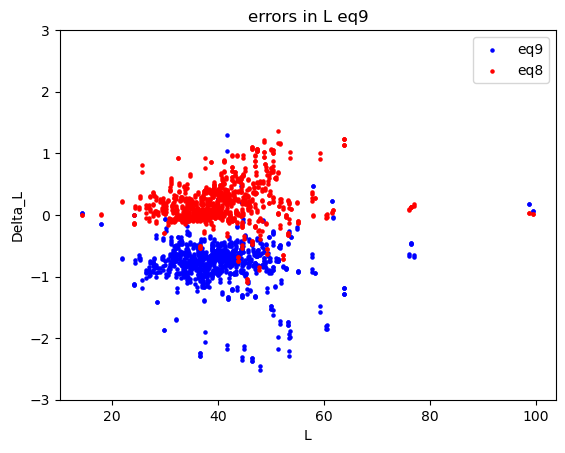

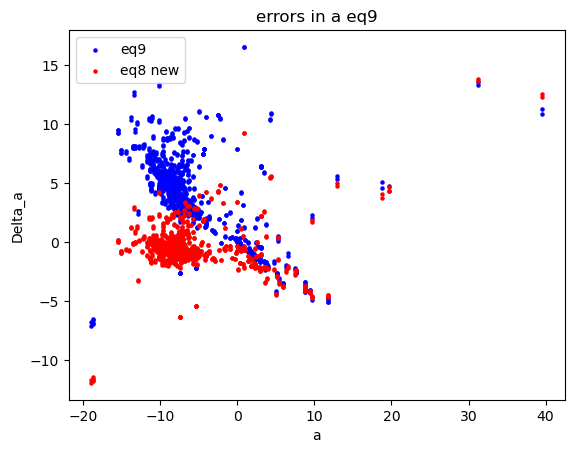

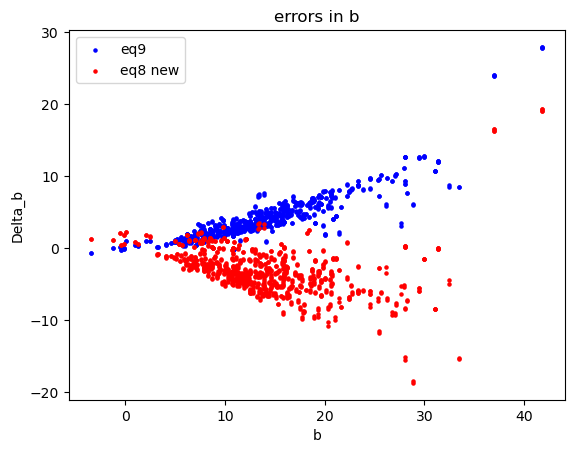

In [10]:
# Fenêtre pour L eq9
plt.figure(1)  # Créer une nouvelle figure (fenêtre)
plt.scatter(L, Delta_L, color='blue', label ='eq9', s=5)
plt.scatter(L_, Delta_L_, color='red', label ='eq8', s=5)
plt.ylim(-3,3)
plt.xlabel('L')
plt.ylabel('Delta_L')
plt.title("errors in L eq9")
plt.legend()


# Fenêtre pour a 
plt.figure(2)  # Créer une nouvelle figure (fenêtre)
plt.scatter(a, Delta_a, color='blue',label ='eq9', s=5)
plt.scatter(a_, Delta_a_, color='red',label ='eq8 new', s=5)
plt.xlabel('a')
plt.ylabel('Delta_a')
plt.title("errors in a eq9")
plt.legend()



# Fenêtre pour b
plt.figure(3)  # Créer une nouvelle figure (fenêtre)
plt.scatter(b, Delta_b, color='blue',label ='eq9', s=5)
plt.scatter(b_, Delta_b_, color='red',label ='eq8 new', s=5)
plt.xlabel('b')
plt.ylabel('Delta_b')
plt.title("errors in b")
plt.legend()

# Afficher le graphique
plt.show()






In [31]:
def plot_scatter(B1,B,dstfile=None):
    X = []
    Y = []
    for i in range(3):
        x = list(B[:,i])
        y = B[:,i] - B1[:,i]
        X.append(x)
        Y.append(y)

    xlabels = ['S2_L','S2_a','S2_b']
    ylabels = ['X','Y','Z']
    legends = [None,None,None]
    fmts = ['o']*len(X)
    solid_markers = [[False,False,False]]*len(X)
    grid = [True]*len(X)
    xlims = [None]*len(X)
    xlims = None
    ylims = xlims
    plot_figures(X, Y, xlabels=xlabels, ylabels=ylabels, titles=None, ncol=3, cell_width=4, cell_height=4,
                     left_margin=0.5, right_margin=0.5, top_margin=0.5, bottom_margin=0.5,fmts=fmts,
                     h_margin=0.8, v_margin=0.5,solid_markers=solid_markers,
                     dstfile=dstfile,xlims=xlims,ylims=ylims)


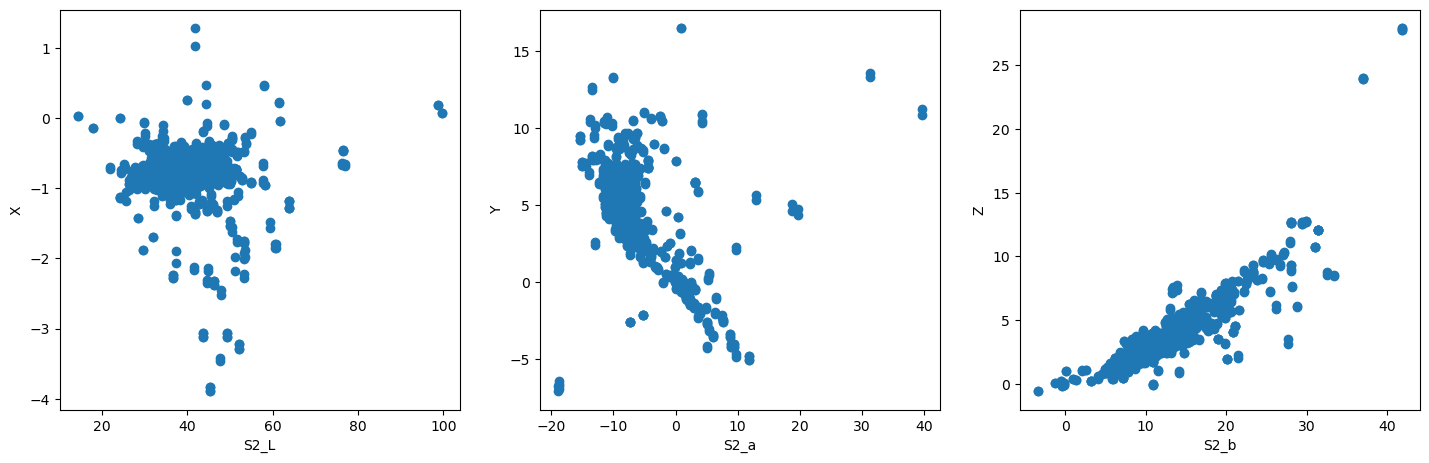

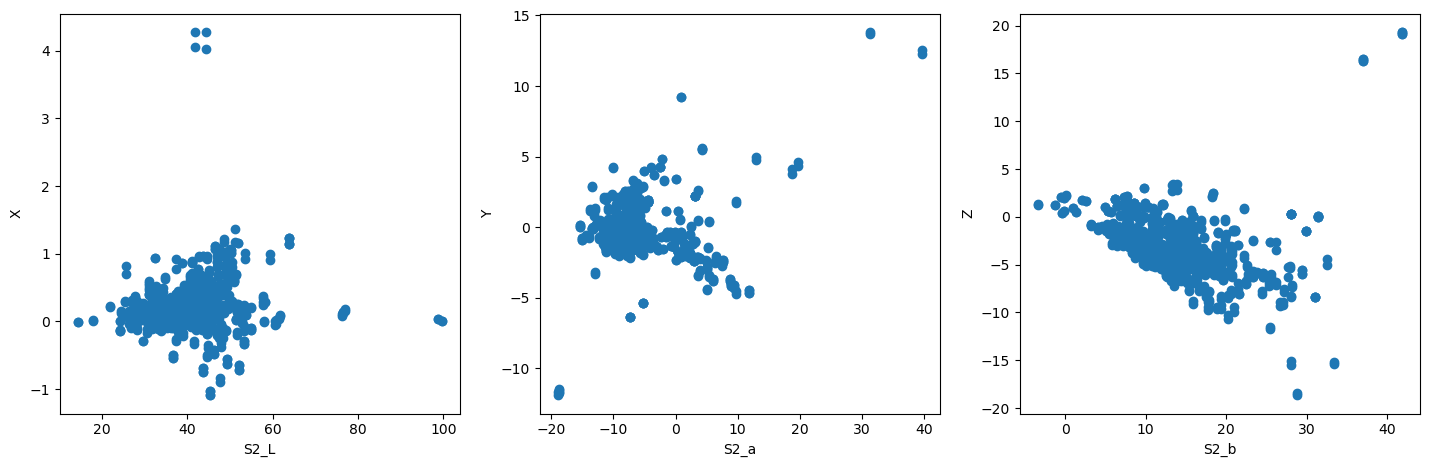

In [32]:
plot_scatter(Lab_sim,Lab,dstfile=None) #eq9
plot_scatter(Lab_sim_,Lab_,dstfile=None) #eq9
